[方法指引](https://docs.google.com/document/d/1nPLGlZV4Zyc6gQkpfBicruGNJMhlB7ZlPID_-vudlQU/edit?usp=sharing)
## 一、 探索外觀特徵與科之間的關係
### 建立簡易的分科模型，提供後續GradCam分析方法，視覺化檢視分科特徵

- 為了進一步了解物種的外觀特徵與科之間的關係，我們首先以代表外觀特徵的 latent vector 為輸入資料，訓練簡單的神經網路模型學習分科，並評估分科表現。為了後續解讀方便，我們將外觀特徵值轉換為非負值。

- 做法是先將對應每張標本影像的 512 維特徵重複堆疊為 1024 維，保留前 512 維裡的正值，與後 512 維裡的負值並取絕對值，其餘維度設為 0。如此即會得到內容全為非負值的外觀特徵。

- 以此為 input，訓練僅兩層全連接 hidden layers (每層各 512 個神經元) 的簡單模型，學習分科 (42 科)，在測試資料集中可達到 90.1% top-1 accuracy。

#### 6/25 討論筆記
- PCA 第零軸: 最主要特徵針對PCA0 兩個peak 內插作圖
- 分群分數 改用原始特徵值決定 N-UNION
- 測試合理的n neighbor(科、亞科)
- 檢視改用亞科作出來的結果

In [1]:
import os, time, random, glob
import torch
import numpy as np 
import pandas as pd
# import PIL
import skimage.io
import skimage.transform
from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
from torch.autograd import Variable
import torchvision 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# plt.style.use('seaborn-whitegrid')
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(12,10)})
path_root =  '/home/jovyan/Autoencoder'

In [2]:
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from umap import UMAP
# import umap.plot

# %matplotlib inline
# %matplotlib widget


if not os.path.exists("meta/embedding/"):
    os.makedirs("meta/embedding/")

#### 建立簡易兩層全連結層的模型

In [3]:
# Define model
class Family_Predictor(nn.Module):
    def __init__(self, in_features=1024, n_neurons=512, n_classes=90):
        super().__init__()
#         super().__init__()
        self.family_Predictor = nn.Sequential(
            nn.Linear(in_features, n_neurons),
            nn.LeakyReLU(negative_slope=0.02, inplace=True),
            nn.Linear(n_neurons, n_classes),
        )

    def forward(self, x):
        pre = self.family_Predictor(x)
        return pre 
    
model = Family_Predictor(in_features=1024, n_neurons=256, n_classes=90) 


In [4]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [5]:
## Define model
# class Moth_FamilyPrediction(nn.Module):
#     def __init__(self, in_features=1024, n_neurons=256, n_classes=97, n_layers=2, shrink_rate=2):
#         super(Moth_FamilyPrediction, self).__init__()
        
#         predic_family = [
#             nn.Linear(in_features, n_neurons),
#             nn.LeakyReLU(negative_slope=0.02, inplace=True)
#         ]
        
#         for _ in range(n_layers):
#             predic_family.extend([
#                 nn.Dropout(0.5),
#                 nn.Linear(n_neurons, int(n_neurons//shrink_rate)),
#                 nn.LeakyReLU(negative_slope=0.02, inplace=True)
#             ])
#             n_neurons //= shrink_rate
#             n_neurons =  int(n_neurons)
        
#         predic_family.extend([
#                 nn.Linear(n_neurons, n_classes),
# #                 nn.LeakyReLU(negative_slope=0.02, inplace=True)
#             ])
#         self.predic_family = nn.Sequential(*predic_family)

#     def forward(self, x):
#         pre = self.predic_family(x)
#         return pre 

# model = Moth_FamilyPrediction(in_features=1024, n_neurons=256, n_classes=97, n_layers=0, shrink_rate=1) 
# model

In [6]:
# # 評估模型摘要
# from torchsummary import summary
# device = torch.device("cpu")
# input_size = (1, 1024)
# batch_size = 64

# summary(model.to(device), input_size=input_size, batch_size=batch_size, device='cpu')

### 資料準備
1. 將對應每張標本影像的 512 維特徵重複堆疊為 1024 維，保留前 512 維裡的正值，與後 512 維裡的負值並取絕對值，其餘維度設為 0。如此即會得到內容全為非負值的外觀特徵。
2. 選取僅物種數超過3種的科
3. 盎樣本類別比例抽樣分配，確保小樣本優先分配至訓練資料集，並在訓練集驗證資料集中均有同樣比例


#### note
- 因為前向傳播在經過relu層時，負值會消失，會導致512維中，負值的維度影響力無法被評估
- 因此採取將負值轉正後，堆疊的方式保留維度訊息


In [7]:
# 讀取特徵值(Latent Vector)，並做轉換
ck = 5000
features = np.load(f'./meta/features_ck{ck}.npy') # features.shape = (32262, 512)

f_pos = np.where(features > 0, features, 0)              # 保留正值，將其他維(負值)設為0 
f_neg = np.abs(np.where(features < 0, features, 0))      # 保留負值，將其他維(正值)設為0，最後取絕對值  
features_1024 = np.concatenate((f_pos, f_neg), axis=1)   # 將原本的512為堆疊為1024維 shape = (32262, 1024)
print(features_1024.shape)

(32262, 1024)


In [8]:
# 讀取蛾類科別metadata
moth_meta = pd.read_csv(f'./meta/moth_meta_20210610.csv')

# 取得檔案名稱加入欄位內
dataroot = "/home/jovyan/Autoencoder/wolrdwide_lepidoptera_yolov4_cropped_and_padded_20210610"
image_list = glob.glob(dataroot + '/*.jpg')  # 如果資料乾淨的話，可直接用 os.listdir(dataroot)
moth_meta['ImgPath'] = image_list

moth_meta 

,Family,Subfamily,Genus,Species,SciName,Number,Source,Family_encode,Fam_Sample,Fam_Specie,ImgPath
0,Notodontidae,Phalerinae,Datana,perspicua,Datana perspicua,2432375495,CSU,60,741,530,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
1,Geometridae,Ennominae,Borbacha,pardaria,Borbacha pardaria,A37-20180907-057,TESRI,34,4684,3138,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
2,Geometridae,Ennominae,Cleora,fraterna,Cleora fraterna,A34-20130506-024,TESRI,34,4684,3138,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
3,Tortricidae,Olethreutinae,Olethreutes,osmundana,Olethreutes osmundana,1838875462,MISSA,84,938,802,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
4,Geometridae,Geometrinae,Hemistola,monotona,Hemistola monotona,A52-20160704-154,TESRI,34,4684,3138,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
...,...,...,...,...,...,...,...,...,...,...,...
32257,Tineidae,Tineinae,Tinea,occidentella,Tinea occidentella,2432338673,CSU,82,102,85,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
32258,Geometridae,Geometrinae,Episothalma,robustaria,Episothalma robustaria,1826442741,NHMUK,34,4684,3138,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
32259,Oecophoridae,Depressariinae,Eupragia,hospita,Eupragia hospita,1585226502,MISSA,62,70,65,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
32260,Nymphalidae,Limenitidinae,Neptis,hylas,Neptis hylas,1039028551,YPM,61,3999,1655,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...


In [9]:
# from sklearn.model_selection import train_test_split
  
# mask = (moth_meta.Fam_Specie > 3)    # 篩選物種數超過3的科(65科) 
# X = features_1024[mask]
# y = moth_meta[mask].Family_encode    # 科名編碼
# X_train, X_valid, y_train, y_valid  = train_test_split(X, y, test_size=0.4, random_state=10, stratify=y)  # 按照y的類別比例取樣

# # 檢視各類別切分比例及數量是否在訓練跟驗證資料集都一致
# print(f'X_train:{X_train.shape}, y_train:{y_train.shape},\nX_valid:{X_valid.shape},  y_valid:{y_valid.shape}')
# # print(f'Class Pro of y_train:\n{np.round(np.bincount(y_train)/y_train.size,3)}')
# # print(f'Class Pro of y_valid:\n{np.round(np.bincount(y_valid)/y_valid.size, 3)}')  
# print(f'Class count of y_train:\n{np.bincount(y_train)}')  # 檢視各類別切分數量，0~96
# print(f'Class count of y_valid:\n{np.bincount(y_valid)}') 

# # save meta data 
# dict_data = {'X_train':X_train, 'y_train':y_train, 'X_valid':X_valid, 'y_valid':y_valid}
# for k, v in dict_data.items():
#     np.save(f'./meta/{k}.npy', v)

In [10]:
## load training data
# X_train, y_train, X_valid, y_valid = [np.load(f'./meta/{f}.npy', allow_pickle=True) 
#                                       for f in ['X_train', 'y_train', 'X_valid', 'y_valid']]
# print(f'X_train:{X_train.shape}, y_train:{y_train.shape},\nX_valid:{X_valid.shape},  y_valid:{y_valid.shape}')

In [11]:
# 準備訓練用的Dataset
class MothFeatureDataset(Dataset):
    def __init__(self, X, y, normalize=False):
        """ 為latent features訓練分科模型用的Dataset
            image_root: path to image file
            X : 放置numpy或list格式資料，這裡的X是形狀為(n,1024) 的蛾類型態Feature Vector
            y : 放置numpy或list格式標籤，這裡為蛾類的科(eccode編碼) 
        """         
        self.X,  self.y= torch.tensor(X), torch.tensor(y)
        self.normalize = normalize  # 將Features座標準化

    def __getitem__(self, index):
        feature = self.X[index]
        label = self.y[index]
        if self.normalize:
            def normalMinMax(features):
                # 將features值 縮放至(0,1)之間
                features_normal = (features - features.min()) / features.max()
                return features_normal
            feature = normalMinMax(feature)    # 標準化為 0 - 1 分布
        return feature, label
    
    def __len__(self):
        return len(self.y)
        
    # help to get images for visualizing
    def getbatch(self, indices):
        features = []
        labels = []
        for index in indices:
            feature, label = self.__getitem__(index)
            features.append(feature)
            labels.append(label)
        return torch.stack(features), labels


class ImgDataset(Dataset):
    '''簡單用來抽樣看原始圖檔的Dataset
        X: ImagePath
        y: Imagelabel(Family, Genus ,Specie Name etc...)
    '''
    def __init__(self, X, y):
        self.ImgNames  = np.asarray(X)                # 輸入的X 為影像完整路徑的list、y則為完整的科名list 
        self.labels = np.asarray(y)
        self.to_tensor = transforms.ToTensor()        # 將取值範圍為[0, 255]的PIL.Image或形狀為[H, W, C]的numpy.ndarray，轉換成形狀為[C, H, W]，取值範圍是[0, 1.0]的torch.FloadTensor
#         self.transform = transforms.Compose([       # 影像必須用PIL開啟才能使用transforms.Compose等系列操作
#             transforms.Resize(size=(128, 128)),
#             transforms.ToTensor()
#         ])
        
    def __getitem__(self, index):
        img_Name = self.ImgNames[index]
#         image = PILImage.open(img_Name)                #  PIL Image讀讀取影像的通道為(c,w,h)
        image = skimage.io.imread(img_Name)              #  skimage.io讀取影像的通道為(w,h,c)，to_tensor會自動調整  
        image = skimage.transform.resize(image, (128,128))
        image = self.to_tensor(image)                    # 根據檔名開啟影像。得到image.jpg的物件，並轉為Tensor
        label  = self.labels[index]
        return image, label
    
    def __len__(self):
        return len(self.labels)
    
    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), labels

# 一次預讀取讀取所有影像 
# X = moth_meta.ImgPath
# y = moth_meta.Family
# img_set = ImgDataset(X=X, y=y)

In [12]:
# # # 設定參數
batch_size  = 500
# num_workers = 2
# pin_memory  = True
# drop_last   = True

# # 客製Dataset載入資料
# train_set = MothFeatureDataset(X=X_train, y=y_train, normalize=True)
# valid_set = MothFeatureDataset(X=X_valid, y=y_valid, normalize=True)

# # DataLoader將資料把包成批次
# train_loader = DataLoader(dataset=train_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory, drop_last=drop_last)
# valid_loader = DataLoader(dataset=valid_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)

# # # 檢視資料形狀、大小
# print(f'Train size : {len(train_set):5d}, iter_size: {len(train_loader):4d}')
# print(f'Valid size : {len(valid_set):5d}, iter_size: {len(valid_loader):4d}')

# features, labels = next(iter(train_loader))
# print('Train data set:', features.shape, labels.shape)   # (batch_size, channel, w, h) 
# features, labels = next(iter(valid_loader))
# print('Valid data set:', features.shape, labels.shape)   # (batch_size, channel, w, h) 


### 定義訓練用函式

In [13]:
model_name = f'Family_Predictor_Batch{batch_size}_Warmpup' 
path = f'./model/family_Predictor/{model_name}.pth'

# 呼叫模型檢查點(Checkpoint)儲存與載入函式
def save_checkpoint(model, optimizer=None, path=None, epoch=None, best_loss=None):
    state = {'model_state_dict'    : model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'epoch':epoch,
             'best_loss':best_loss}
    torch.save(state , path)

def load_checkpoint(model, path, optimizer=None):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch_ = checkpoint['epoch']
    best_loss_ = checkpoint['best_loss']
    
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(optimizer)

    print(f'best_loss:{best_loss_:.4f}')
    print(f'{model_name}.pth loaded!')
    return model

In [14]:
# # 檢查變數是否已命名
# try:
#     train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log
#     print('log file has bean setted')
# except NameError:
#     train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log  = [], [], [], [], []
#     print('log file resetted:\n    train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log')

# # 檢查資料夾是否已建立
# logRoot =  "./model/family_Predictor"
# if not os.path.isdir(f'{logRoot}'):
#     os.mkdir(f'{logRoot}')
#     print(f'"{logRoot}" folder made!')
    
# # save Loss log
# def save_log(fileName=None):
#     '''儲存學習過程'''
#     (pd.DataFrame({"train_Loss":train_log   , 'valid_Loss':valid_log, 
#                    'train_Acc':train_Acc_log, 'valid_Acc' :valid_Acc_log,
#                    'lr':lr_log})
#        .to_csv(f'{logRoot}/Loss_log_{fileName}.csv', index=False))

# def getAccuracy(pred, labels, correct, total):
#     '''計算分類正確率，在train及evaluate函式中使用'''
#     pred_ = torch.argmax(pred, dim=1)              # 取得最大值的索引位置(0~9)
#     correct += (pred_ == labels).sum().item()      # 累加預測正確的樣本數
#     total += labels.size(0)                        # 累加每批次樣本數
#     return (100*correct / (total+1e-10))             # 回傳分類正確率


# def train(model, optimizer, dataloader, device):
#     '''訓練模型，輸入訓練資料集'''
#     running_loss, correct ,total = 0.0, 0.0, 0.0   # 每輪歸零重計
#     model.train()  # 明確指定model在訓練狀態(預設值)
#     for i, (inputs, labels) in enumerate(dataloader):
#         inputs, labels = inputs.to(device), labels.to(device)  
#         optimizer.zero_grad()                          # 將優化器梯度歸零 
#         pred = model(inputs)                            
#         loss = criterion(pred, labels)                 # 計算LOSS ， 調整為形狀一致
#         loss.backward()                                # 反向傳導
#         optimizer.step()                               # 更新參數
#         running_loss += loss.item()                    # 累加這輪epoch的loss 
#         # get accuracy
#         acc = getAccuracy(pred, labels, correct, total)     
#     # 每輪epoch結束後取平均loss、計算分類正確率 
#     mean_loss = running_loss/i
#     train_log.append(mean_loss); train_Acc_log.append(acc)
#     lr_log.append(optimizer.param_groups[0]['lr']) 
#     return mean_loss , acc                             # 回傳平均loss, 分類正確率  

# def evaluate(model, dataloader, device):
#     '''評估模型，輸入驗證/測試資料集'''
#     running_loss, correct ,total = 0.0, 0.0, 0.0   # 每輪歸零重計
#     model.eval() # 啟動評估模式
#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloader):  
#             inputs, labels = inputs.to(device), labels.to(device)
#             pred = model(inputs)
#             loss = criterion(pred, labels)
#             running_loss += loss.item()
#             acc = getAccuracy(pred, labels, correct, total) 
            
#         # 每輪epoch結束後取平均loss
#     mean_loss = running_loss/i
#     valid_log.append(mean_loss); valid_Acc_log.append(acc)
#     return mean_loss , acc

# def early_stop(valid_loss, best_loss, trigger_times, patience):
#     '''早停機制
#     trigger_times: 計數次數
#     patience:　啟動後。等待幾回合
#     '''
#     if valid_loss > best_loss:
#         trigger_times += 1
#         print('  trigger times:', trigger_times)
#     else:
#         trigger_times = 0
        
#     if trigger_times >= patience:
#         print('  Early stopping!')
#     return trigger_times

In [15]:
# # 設定optimizer
# import torch.optim as optim
# from torch.optim import lr_scheduler

# criterion = nn.CrossEntropyLoss() 
# optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)


In [16]:
# def training_model(n_epoch, optimizer, scheduler):
#     start = time.time()
#     best_loss=1e10 ; patience=20 ; trigger_times=0 # 設定初始值
#     for epoch in range(n_epoch):  # loop over the dataset multiple times
#         pass_ = time.time() - start
#         print(f'Epoch:{epoch+1 :3d}.  Time Passed: {pass_//(60*60):3.0f}h,{pass_//60%60:2.0f}m,{pass_%60:2.0f}s')
        
#         train_loss, valid_loss= 0.0, 0.0 # 每輪重新歸零

#         train_loss, train_Acc = train(model, optimizer, train_loader, device)
#         print(f'  Train Loss: {train_loss:,.3f}. Acc: {train_Acc:,.2f}%')

#         valid_loss, valid_Acc = evaluate(model, valid_loader, device)             
#         print(f'  Valid Loss: {valid_loss:,.3f}. Acc: {valid_Acc:,.2f}%')

#         # 擷取最佳模型
#         if best_loss > valid_loss:
#             decline = (best_loss-valid_loss)/best_loss*100
#             best_loss = valid_loss
#             save_checkpoint(model, optimizer, path, epoch, best_loss)            
#             print(f'  Best loss updated: {best_loss:,.3f}, {decline:.2f}% declined.  Model Saved!') 

#         # 更新學習速率
#         scheduler.step(valid_loss)
#         print(f'  lr_sch : {scheduler._last_lr[0]}')
        
#         # 儲存log
#         save_log(fileName=model_name)

#         # early stopping
#         trigger_times = early_stop(valid_loss, best_loss, trigger_times, patience)
#         if trigger_times >= patience:
#             print('Early stopping!')
#             break
    
#     print(f'Best val_loss: {best_loss:,.3f}')
#     print(f'Finished Training\n')


In [17]:
# # 模型預熱 Warmpup 
# optimizer = optim.Adam(model.parameters(), lr=1e-8, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(10, optimizer, scheduler)

# optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(10, optimizer, scheduler)

# optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(10, optimizer, scheduler)

# optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(10, optimizer, scheduler)

In [18]:
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(500, optimizer, scheduler)

In [19]:
# # 作圖
# def get_LossFig(figName=None, s=0, e=-1 , savefig=False):
#     '''繪製學習過程圖
#     Parameters
#      ----------
#        figName: str, default: None
#        s: number(int) , default: 0, start of epoch.  number(int) 
#        e: number(int) , default: 0, end of epoch. 
#        savefig: boolean
#            whether to save
#    '''
#     log = pd.read_csv(f'{logRoot}/Loss_log_{figName}.csv')
#     log = log[s:e] 
#     fig = plt.figure(figsize=(10,5))
#     ax1 = fig.add_axes([0, 0.0, 1, 0.8],)
#     ax2 = plt.twinx()
#     ax3 = fig.add_axes([0, 0.8, 1, 0.2], xticklabels=[])

#     ax1.plot(log.train_Loss, label='Train_Loss', c='tab:blue', lw=3)
#     ax1.plot(log.valid_Loss, label='Valid_Loss', c='lightblue', lw=3, ls='--'  )
#     ax2.plot(log.train_Acc, label='Train_Accuracy', c='tab:green', lw=3)
#     ax2.plot(log.valid_Acc, label='Valid_Accuracy', c='lightgreen', lw=3, ls='--' )
#     ax3.plot(np.log10(log.lr), c='grey')   # lr取log 

#     plt.title('LOSS', {'fontsize':18})
#     plt.suptitle(f'batch:{batch_size}', x=0.8, y=1.05, fontsize=12, fontweight='light')
#     ax1.set_xlabel('Epoch',{'fontsize':12}); ax1.set_ylabel('Loss',{'fontsize':12})
#     ax2.set_ylabel('Accruracy(%)',{'fontsize':12}); ax3.set_ylabel('lr(log)',{'fontsize':12})
#     ax1.grid(True)
#     fig.legend(loc='upper left', ncol=2, bbox_to_anchor=(0.7, 0.6), frameon=True, framealpha=.5, fontsize=12 ) 
    
#     # 圖片存檔
#     if savefig:       
#         plt.savefig(f'{logRoot}/Loss_{figName}.png', bbox_inches='tight')
#     fig; 
    
# get_LossFig(figName=model_name, savefig=True)

In [20]:
# load_checkpoint(model, path)

# # 檢視驗證資料集整體分類正確率 
# valid_loader = DataLoader(dataset=valid_set, batch_size=1280)
# correct = 0
# total = 0
# with torch.no_grad():
#     for inputs, labels in valid_loader:
#         inputs, labels = inputs.to(device), labels.to(device) # 把資料送入GPU(非inplace)

#         # 計算圖片在每個類別上的分數
#         outputs = model(inputs)
#         # 得分最高的那個類別
#         _, predicted = torch.max(outputs.data, 1)
                
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# #         print(f'total : {total:5d}, correct : {correct:5d}')
# #         accuracy = (torch.argmax(outputs, dim=1) == labels).sum().item() / batch_size

# print(f'Accuracy of the network on the  valid data: {(100 * correct / total):.2f} %, Sample_Size : {total:5d}')
# # 整體分類正確率約為92%

In [21]:
# # 建立科名encoing的字典對照表 
# fam_dict = dict(zip(np.sort(moth_meta.Family.unique()), range(97) ))           # 依科名英文字母順序建立編碼

# # # 檢視驗證資料集各類別分類正確率 
# classes= [k for k in fam_dict.keys()]
# n_classes = 90
# class_correct = list(0 for i in range(n_classes))
# class_total = list(0 for i in range(n_classes))
# with torch.no_grad():
#     for inputs, labels in valid_loader:
#         inputs, labels = inputs.to(device), labels.to(device) # 把資料送入GPU(非inplace)
        
#         # 計算圖片在每個類別上的分數
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(outputs.size(0)):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# print('Accuracy of each class')         
# # for i in range(n_classes):
# #     accuracy = 100 * class_correct[i] / (class_total[i] + 1e-10)  # 加上極微小的數值避免分母為0
# #     print(f'Family {classes[i]:20s} : {accuracy:6.3f} %')

# acc_df = pd.DataFrame({'Family':classes, 'Correct':class_correct, 'Total':class_total})
# acc_df['Accuracy'] = acc_df.Correct / (acc_df.Total + 1e-10)  # 加上極微小的數值避免分母為0
# acc_df = acc_df.sort_values(by='Total')[::-1]

logRoot =  "./model/family_Predictor"
LogFile = f'accuracyLog_Batch500'
# acc_df.to_csv(f'{logRoot}/{LogFile}.csv', index=True)

acc_df = pd.read_csv(f'{logRoot}/{LogFile}.csv', index_col=0)
acc_df[acc_df.Total>0][:20]
acc_df['cumsum'] = acc_df["Total"].cumsum()
acc_df['Total%'] = acc_df['cumsum'] / acc_df.iloc[-1,-1]
acc_df[:20]

,Family,Correct,Total,Accuracy,cumsum,Total%
27,Erebidae,1881,2060,0.913107,2060,0.160037
34,Geometridae,1819,1874,0.970651,3934,0.305625
61,Nymphalidae,1575,1600,0.984375,5534,0.429925
58,Noctuidae,1362,1480,0.920270,7014,0.544904
65,Pieridae,1221,1233,0.990268,8247,0.640693
39,Hesperiidae,576,585,0.984615,8832,0.686140
48,Lycaenidae,485,513,0.945419,9345,0.725994
19,Crambidae,427,478,0.893305,9823,0.763129
64,Papilionidae,434,438,0.990868,10261,0.797157
84,Tortricidae,359,375,0.957333,10636,0.826290


In [22]:
## 指定物種顯示原始影像

# X = moth_meta.ImgPath
# y = moth_meta.Family
# img_set = ImgDataset(X=X, y=y)

# specie = 'Anthocharis sara'
# img_indices =  moth_meta[moth_meta.SciName == specie].index

# images ,labels = img_set.getbatch(img_indices)
# family_ = np.unique(labels).item()
# im_convert(torchvision.utils.make_grid(images, nrow=6), f_name= f'{family_}_{specie}', subtitle=len(y), save=False)

### 分科模型訓練筆記
- 整體分類正確率的極限大約在92-93%，各類別的分類正確率不太受batch size影響，也不太受Warmup影響，可能跟模型太過簡單有關
- 數量排名前五大科，占總樣本數的65%、數量排名前十大科，占總樣本數的83.5%、數量排名前二十大科，占總樣本數的95.8%
- 數量排名前十大科，平均分類正確率達96.6%、數量排名前二十大科，平均分類正確率達90.1%
- 各科狀況討論
  - 數量排名前五大科中，除裳蛾科Erebidae、夜蛾科Noctuidae外，分類正確率都達98%以上
     - 可能反映屬夜蛾總科下的這兩科型態上多有相似之處
     - 可檢視這兩科的分類標籤是否分配到彼此
  - Sesiidae 透翅蛾科雖然樣本不多，但因為翅型特殊，仍可以取得很高的分類正確率97.8%, n=46 (from validation dataset)
  - 數量前二十大的科別中，瘤蛾科Nolidae(57.0%)、鉤蛾科Drepanidae(65.2%)是分類預測表現相對差的類群
  - 數量前三十大的科別中，蜆蝶Riodinidae~分類正確率為0.0%，異常的低(總物種28、總樣本60)~
     - 總科數量較正為90後，蜆蝶Riodinidae分類正確率為提升為77%左右，原樣本有重新整理過(總物種148、總樣本增加至276)
- 檢視分類錯誤的標籤即對應的科名、與原圖
- 檢視GradCAM分類所對應的區域?
  - 由於是用特徵向量(latent features)訓練，因此反向傳播回推也只能到特徵維度
  - 找時間用映妤訓練用的ResNet50模型回去檢視分科的判斷依據、以及特徵圖視覺化
  

In [23]:
## 檢視各科樣本數量分布
# moth_sample = (moth_meta.groupby(by='Family')[['SciName','DataID']]
#                .nunique().rename(columns={'SciName':'n_Species', 'DataID':'n_Samples'})
#                .sort_values(by='n_Species')[::-1] )
# moth_sample['n_Species%'] = np.round(100 * moth_sample.iloc[:,0] / moth_sample.n_Species.sum(), 3)
# moth_sample['n_Samples%'] = np.round(100 * moth_sample.iloc[:,1] / moth_sample.n_Samples.sum(), 3)
# moth_sample[:10]


#### 抽樣檢視原始影像

In [24]:
# # 建立科名encoing的字典對照表 - YY版本
# worldwide_family = np.load('./meta/worldwide_family.npy') 
# fam_dic_YY = dict(zip(range(97), worldwide_family))                  # 依YY檔案建立科名排序編碼

# # 建立物種名的字典對照表
# n_species = moth_meta.SciName.nunique()  # 17186
# species_list = moth_meta.sort_values(by='SciName').SciName.unique()
# spe_dict = dict(zip(range(n_species), species_list))

# dataroot = "/home/jovyan/Autoencoder_Practice/wolrdwide_lepidoptera_yolov4_cropped_and_padded_20210407"
# image_list = glob.glob(dataroot + '/*.jpg')
# moth_meta['ImgName'] = image_list

In [25]:
# fig_path =  f"./results/Feature_inverse"
def im_convert(tensor, f_name=None, subtitle=None, save=False, fig_root=None, figsize=(12,3)):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0).clip(0,1)              # (c,w,h) > (w,h,c)
    plt.figure(figsize=figsize)
    plt.title(f'{f_name}', fontsize=24)
    plt.imshow(image)
    
    if save:
        fig_path =  f"{fig_root}/{f_name}.png"
        plt.savefig(fig_path, bbox_inches='tight')
        print(f'{fig_path} Saved')

## 二、找出關鍵特徵
- 接著我們將找出每科的 top N 個重要分類特徵 (i.e. 對分科有最大影響力的 top N 維度)，並將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。我們視低維度的關鍵特徵為同時具有分辨力 (recognition) 與代表性 (representation) 的蛾標本影像特徵，並用於後續的分析與視覺化的解釋。

- 我們借用 Grad-CAM 的概念以找出分科的重要外觀特徵，透過反向傳播演算法 (back propagation) 求出分科模型中對應於每個輸入值的 gradient vector，是為特徵關注度向量。我們在此計算每個物種的平均特徵關注度，並以 voting 的方式，決定每個科的重要特徵。

- Voting 的規則是，先從物種平均特徵關注度的向量中，找出最大的 N 個值的位置，每個位置視為得到一票；接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。 
      
- 我們希望以最小但又具足夠鑑別度的 N 與 N-union 來描述與代表科的特徵。我們窮舉 N = 1 ~ 50 這個範圍中對應的 N-union 個關鍵特徵。基於每個物種在關鍵特徵空間中的 embedding，依科計算分群的三個指標 (Silhouette Coefficient, Calinski and Harabasz score, 與 Davies-Bouldin score)，標準化並加總評估後得到當 N=2, N-union=34 時有最佳的科分群結果，約為總特徵數的 6.6% (34/512)。

- 為了更進一步理解關鍵特徵的視覺意義，我們對其做 PCA，找出最主要的三軸(解釋度 34.9%)。接著在三軸上均勻取樣並 inverse transform 回關鍵特徵。從 decoder 生成的影像中，可明確看出每一軸在外觀特徵上的意義，是為：展翅大小、翅膀形狀，與翅膀上的紋路(圖5)。
      
- 我們亦在 PCA 轉換後的特徵空間上找出每科的凸包 (convex hull) 與對應的頂點 (vertices)。對頂點 (vertices) 的物種特徵解碼，便能找出每科的外觀變異極致型的影像。換句話說，每科的物種外觀變異將介於這些特定型之間。圖6 以蛾的四大科為例做視覺化示範。


### note: 
- 想找出分科的關鍵特徵還有哪些方式? 
  - 目前概念是以梯度為根據，還有哪些方式能量化評估特徵重要性?  
      - 採用梯度積分?
- 上述的方式還能做那些調整? 
  - 以物種為單位? 、以科為單位?
- 用類別回推 ，該用實際類別 還是預測類別，特別是對於一些小樣本，模型並沒有學會對該科的辨識能力
  - 分析時取用分類正確率達一定程度以上的科別?

### 2.1 取得物種平均特徵關注度
- 接著我們將找出每科的 top N 個重要分類特徵 (i.e. 對分科有最大影響力的 top N 維度)，並將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。我們視低維度的關鍵特徵為同時具有分辨力 (recognition) 與代表性 (representation) 的蛾標本影像特徵，並用於後續的分析與視覺化的解釋。

- 我們借用 Grad-CAM 的概念以找出分科的重要外觀特徵，透過反向傳播演算法 (back propagation) 求出分科模型中對應於每個輸入值的 gradient vector，是為特徵關注度向量。我們在此計算每個物種的平均特徵關注度，並以 voting 的方式，決定每個科的重要特徵。

- Voting 的規則是，先從物種平均特徵關注度的向量中，找出最大的 N 個值的位置，每個位置視為得到一票；接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。 


In [26]:
# model = load_checkpoint(model, path)
# model.cpu()

In [27]:
# 建立科名encoing的字典對照表 
fam_dict = dict(zip(range(97),np.sort(moth_meta.Family.unique())))        # 依科名英文字母順序建立科名編碼

# 建立物種名的字典對照表
n_species = moth_meta.SciName.nunique()  # 17186
species_list = moth_meta.sort_values(by='SciName').SciName.unique()
# species_dict = dict(zip(range(n_species), species_list))
species_dict = dict(zip(species_list, range(n_species)))

In [28]:
def get_cam(inputs, model, index=None):
    '''
    inputs : mophological latent features of moth.  torch.Size([n_batch, 1024)]
    index : labels of inputs.(Family)
    outputs : grad of inputs
    ''' 
    # 由於想要求得inputs即特徵值在各維度的重要性(d =1024)，因此需要開啟需要導數的設定
#     inputs_ = torch.tensor(inputs) 
#     features = Variable(inputs_, requires_grad=True) # switch on requires_grad, for geting features.grad depend y later
    features = inputs.clone().detach().requires_grad_(True)
    model.eval()
    model.zero_grad()
    pred = model(features)                           # inputs: torch.Size([n_batch, 1024)], outputs: torch.Size([n_batch, n_classes])
    
    if index is None:                                # size = n_batch, 取得各筆資料的分類預測結果
        index = np.argmax(pred.detach().numpy(), axis=1) 
    
    #參照GradCam概念，以該筆資料所預測的類別做Backpropagation回推求導，作為評估該分類結果的參考依據
    # pred * one_hot => 將該筆資料預測結果以外的類別均設為0，則可求得該預測類別bp回推的導數
    one_hot = torch.zeros(pred.shape)
    for i in range(len(index)):                      # len(index): batch size 
        p = index[i].item()                          # get prediction result/position    
        one_hot[i][p] = 1                            # transform pred as onehot encode
    
    class_ = torch.mul(pred, one_hot).sum()          # element wise dot => get scalar.  (pre * one_hot).sum() or  
    class_.backward()                                # 先將兩個相同形狀的tensor做逐元素相乘後取總和得到純量後，再做Backpropogation
#     pred.backward(one_hot)  # same as (pre * one_hot).sum().backward() or torch.mul(pred, one_hot).sum().backward()
    inputs_grad = features.grad.clone().detach().numpy()

    return inputs_grad, index    # 特徵值的導數 shape: (n_batch, 1024)，亦即特徵關注度

In [29]:
# # 透過dataset送入資料
# X = features_1024
# y = moth_meta.Family_encode.values
# feature_data_set = MothFeatureDataset(X=X, y=y, normalize=True)

In [30]:
# start_time = time.time()
# for i, specie in enumerate(species_list):
#     indices_specie_feature =  moth_meta[moth_meta.SciName == specie].index   # 取得指定物種的指標位置
#     features, labels = feature_data_set.getbatch(indices_specie_feature)     # 取得指定物種的特徵與標籤   
#     features_grad, index_pred = get_cam(features, model, index=labels)       # 取得指定物種的導數(GradCam)與預測類別
    
#     # 物種的平均特徵關注度: 按物種取所有樣本平均後再取絕對值，因為導數反應的是Loss(這裡是類別)對其影響的變化程度，因此不分正負
#     features_grad_mean_  = np.abs(np.mean(features_grad, axis=0))            # 計算物種的平均特徵關注度 
    
#     if i == 0 :
#         features_grad_mean = features_grad_mean_.reshape(1,1024)
#     else:
#         features_grad_mean = np.concatenate((features_grad_mean_.reshape(1,1024), features_grad_mean), axis=0)
        
#     time_pass = time.time()-start_time
#     print(f"{i+1:5d}, {100*(i+1)/len(species_list):.2f}%. \
#     Time: {time_pass/60%60 :.0f}m, {time_pass%60 :.0f}s, \
#     features_grad_mean: {features_grad_mean.shape}", end='\r')

file_features_grad_mean = "features_grad_mean.npy"
# np.save(f'{path_root}/meta/{file_features_grad_mean}', features_grad_mean)

# # 以物種為單位的、所有物種的平均特徵關注度 (17186, 1024)
features_grad_mean = np.load(f'{path_root}/meta/{file_features_grad_mean}', allow_pickle=True)

- Voting 的規則是，先從物種平均特徵關注度的向量中，找出最大的 N 個值的位置，每個位置視為得到一票；
- 接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。
  - 以科為單位，而不是以物種為單位

In [31]:
df_Specie_Family = (moth_meta.groupby(["Family","SciName"]).count().sort_values("SciName")
                    .reset_index()
                    .loc[:, ["SciName" , "Family"]]
                   )
df_Specie_Family

,SciName,Family
0,Abaciscus alishanensis,Geometridae
1,Abaciscus intractabilis,Geometridae
2,Abaciscus tristis,Geometridae
3,Abaeis nicippe,Pieridae
4,Abagrotis alampeta,Noctuidae
...,...,...
17181,Zygaena trifolii,Zygaenidae
17182,Zygaena viciae,Zygaenidae
17183,Zygophyxia relictata,Geometridae
17184,Zythos avellanea,Geometridae


### 2.2 透過降維後分群，找出最小又具鑑別的主成分數量(N, n_components) 及 關鍵特徵數量(N-union)
- 我們希望以最小但又具足夠鑑別度的 N 與 N-union 來描述與代表科的特徵。我們窮舉 N = 1 ~ 50 這個範圍中對應的 N-union 個關鍵特徵。基於每個物種在關鍵特徵空間中的 embedding，依科計算分群的三個指標 (Silhouette Coefficient, Calinski and Harabasz score, 與 Davies-Bouldin score)，標準化並加總評估後得到當 N=2, N-union=34 時有最佳的科分群結果，約為總特徵數的 6.6% (34/512)。

#### 計算在 N(topk) = 1 -50 ，  n_union在特徵向量的指標

In [32]:
# start_time = time.time()
# indexes = []
# index_n_unions = []
# for topk in np.arange(1,51): # 取　1 - 50重要特徵
#     index_specie_topk = np.argsort(features_grad_mean)[:, -1 -(topk-1): ]  # (17186, topk) 物種平均特徵關注度的向量中，找出最大的 N 個值的位置
# #     print('index_specie_topk : ', index_specie_topk.shape)

#     # 根據指定的特徵數量( topk)，將指定位置的值轉為 1 ，其餘為0 (voting value = 1 )
#     features_topk_specie = np.zeros_like(features_grad_mean, dtype="uint16")
#     for i, index in enumerate(index_specie_topk):
#         features_topk_specie[i][index]=1
        
#     # 接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。
#     for k, family in fam_dict.items():
#         # 根據index位置篩選出該科所有物種，並進行加總，得到以科為單位、長度為1024維的向量
#         index_Family_Specie = df_Specie_Family[df_Specie_Family.Family == family].index.values
#         features_topk_family_ =  np.sum(features_topk_specie[index_Family_Specie], axis=0)     #  shape (1024,) 。 該科經過所有物種投票後得到的所有重要特徵維度 
#         if k==0:
#             features_topk_families_ = features_topk_family_.reshape(1, -1)
#         else:
#             features_topk_families_ = np.concatenate(
#                 (features_topk_families_, features_topk_family_.reshape(1, -1)),
#                 axis = 0
#             )
# #     print("features_topk_families : ", features_topk_families.shape)

#     # 這一步可能需要修正，應該只在物種層次取topk，科的層級則取聯集
#     index_family_topk = np.argsort(features_topk_families_)[:, -1 -(topk-1): ]  # (number of family, topk) 指定每個科當中總得票最高的N個位置(亦即各科 topk=N 個重要關鍵特徵位置) 
# #     print('index_family_topk : ', index_family_topk.shape)

#     # 根據指定的特徵數量( topk)，將指定位置的值轉為 1 ，其餘為0 (voting value = 1 )
#     features_topk_families = np.zeros_like(features_topk_families_, dtype="uint16")
    
#     for i, index in enumerate(index_family_topk):
#         features_topk_families[i][index]=1

#     features_topk_families_voting = np.sum(features_topk_families, axis=0)       # 求各科關鍵特徵的聯集 
#     index_ = np.where(features_topk_families_voting > 0)[0]                      # 取得 n_union指標位置(1024維)
#     index_n_union_ = np.where(index_ > 511, index_ - 512, index_)                # 轉換維原本維度(512維)
#     index_n_union = np.unique(index_n_union_)                                    # 去掉重複的維度 
    
#     indexes.append(index_)
#     index_n_unions.append(index_n_union)
    
#     time_pass = time.time()-start_time
#     print(f'Time: {time_pass/60%60 :.0f}m, {time_pass%60 :.0f}s. topk : {topk}, n_union : {len(index_n_union):3d} ', end="\r")

# np.save(f'{path_root}/meta/index_n_unions.npy', index_n_unions)
index_n_unions = np.load(f'{path_root}/meta/index_n_unions.npy', allow_pickle=True)
df_Nuniun = pd.DataFrame([len(n) for n in index_n_unions], index=range(1,51), columns=["N_uniun"] )

- 在透過GRADCAM得到各維度導數時(變化程度，反映對於分科結果的重要性)，1024維的特徵中，因為負值而被堆疊到後512維並取絕對值的維度中， 原本的維度及取正值堆疊後的位置(例如原本維度是10，因為其為負值而在原位置指定為0，而被堆疊到 10+512 =522 的位置)，有可能在GRACAM操作時，因為均反映分科重要性而在後面取值時同時取到(例如，維度10與維度522其實是同樣位置)
- 合理現象，因為重要的位置，即使原來的位置是0也還是重要
-  那原本堆疊成 512 + 512的用意?  思考整個處理流程，有需要特別處理負值?

-  事後處理策略:
  - 將堆疊的維度-512換算回原本位置後，再去掉重覆(取unique)
  - ~保留原本取負值的index位置，根據index 位置轉回去(但原本就是直接+512了  其實用前者的方法即可)~
   


In [33]:
## 檢視n_unions的數量分布及維度重疊的程度
# df_n_unions = pd.DataFrame( [
#     [len(n) for n in indexes],
#     [len(n) for n in index_n_unions],
# #     [np.count_nonzero(np.unique(n)) for n in index_n_unions]
# ],
#     columns=np.arange(1,51), 
#     index= ["indexes", 
#             "n_union", 
# #             "n_union_unique"
#            ] 
# ).T

# plt.figure();
# ax = df_n_unions.plot( figsize=(12,3),grid=True)
# ax.set_ylabel("N_UNION");
# ax.set_xlabel("N");


In [34]:
def get_embedding(reducer="PCA" , features=None, n_components=2, n_neighbors=200, path_root=path_root, index=None, save=False):
    
    if reducer == "UMAP": 
        umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, verbose=True)
        embedding_ = umap.fit_transform(features)
    if reducer == "PCA": 
        pca = PCA(n_components=n_components)
        embedding_ = pca.fit_transform(features)
        
    if save == True:
        embedding_file = f"{reducer}_embedding_{n_components}D_{index}N.npy"
        path =  f'{path_root}/meta/embedding/{reducer}/{embedding_file}'
        np.save(path, embedding_)
#         print(f'\t{embedding_file} saved') 
    

In [35]:
# for i, index in enumerate(index_n_unions):
#     print(f'{i+1:2d}, Number of features: {len(index):2d}')
#     mask = ~np.isin(np.arange(512), index)  # 透過反向選取，篩選出非關鍵維度  
#     index_inverse = np.arange(512)[mask]
   
#     features_ = features.copy()      # 每次要重新使用copy assign features_ ，否則原始資料會被覆蓋
#     features_[:, index_inverse] = 0
#     get_embedding(reducer="PCA", features=features_, n_components=2, index=(i+1), save=True)
#     get_embedding(reducer="PCA", features=features_, n_components=3, index=(i+1), save=True)

#### 分群評估改用原始特徵輸入
- 保留不同的關鍵特徵

In [36]:
def get_Nunion_features (features=None, n=None, index_n_unions=index_n_unions):
    index = index_n_unions[n-1]
    mask = ~np.isin(np.arange(512), index)  # 透過反向選取，篩選出非關鍵維度  
    index_inverse = np.arange(512)[mask]
    
    features_ = features.copy()      # 每次要重新使用copy assign features_ ，否則原始資料會被覆蓋
    features_[:, index_inverse] = 0  # 將沒被選擇到的維度，數值凍結為0
    return features_

In [37]:
def clustering_metric_score(metric="silhouette" , n_range=None):
    '''
        metric = "silhouette" or "calinski_harabasz" or "davies_bouldin"
    '''
    scores = []
    for n in n_range:
        features_ = get_Nunion_features (features=features, n=n, index_n_unions=index_n_unions)
        
        if metric == "silhouette":
            score = metrics.silhouette_score(features_, moth_meta.Family)
        if metric == "calinski_harabasz" :
            score = metrics.calinski_harabasz_score(features_, moth_meta.Family) 
        if metric == "davies_bouldin" :
            score = metrics.davies_bouldin_score(features_, moth_meta.Family) 
        
        scores.append(score)
        print(f'N: {n:2d}, {metric} Score: {score:.3f} ', end='\r')
    return scores

In [38]:
# n_range = np.arange(1,51)
# sil_scores, ch_scores, db_scores = [], [], []

# for metric in ["silhouette", "calinski_harabasz", "davies_bouldin"]:
#     score = clustering_metric_score(metric=metric , n_range=n_range)
#     if metric == "silhouette":
#         sil_scores += score
#     if metric == "calinski_harabasz":
#         ch_scores += score 
#     if metric == "davies_bouldin":
#         db_scores += score

In [39]:
# data = [sil_scores, ch_scores, db_scores]
# metric_score = pd.DataFrame(
#     np.array(data).T,
#     index=n_range,
#     columns=["silhouette" , "calinski_harabasz", "davies_bouldin"]
#             )

# metric_score.to_csv(f'meta/clustering_metric_score_features.csv')
metric_score = pd.read_csv(f'meta/clustering_metric_score_features.csv',header=[0], index_col=0)
# metric_score.index = df_Nuniun.N_uniun
# metric_score.sort_index(inplace=True)

In [40]:
 #　將三個metric標準化處理，取值在0~1。
metric_score.davies_bouldin = metric_score.davies_bouldin*-1  # davies_bouldin為越小越佳，因此先乘上負號
metric_score_ = (metric_score -  metric_score.min()) / (metric_score.max() -  metric_score.min())
# idx = pd.IndexSlice
# metric_score_.loc[:, idx[:, "2D"]].sum(axis=1)
# metric_score_.loc[:, idx[:, "3D"]].sum(axis=1)
metric_score_merge = metric_score_.sum(axis=1)

print("N / N_uniun : \n", metric_score_merge.idxmax())  # 檢視分群最佳結果的 N_union
print()
print("Score : \n", metric_score_merge.max())


N / N_uniun : 
 5

Score : 
 2.6631879610926354


In [ ]:
# figsize=(12, 2); marker="."; lw = 2
# metric_score_merge.plot(title="Clustering_Score_Merge" , grid=True, figsize=figsize, lw=lw, marker=marker);         # 三個指標標準化後加總

In [ ]:
# metric_score.silhouette.plot(title="Silhouette_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

In [ ]:
# metric_score.calinski_harabasz.plot(title="Calinski_Harabasz_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

In [ ]:
# metric_score.davies_bouldin.plot(title="Davies_Bouldin_Score",grid=True, figsize=figsize, lw=lw, marker=marker);

#### Note:
- N=5，N-union=61時，有最佳的科分群結果(2.66)，約為總特徵數的 11.9% (61/512)
- 作圖檢視，clustering結果與metric_score分數一致，並不是使用越多特徵、分群效果就越明顯  

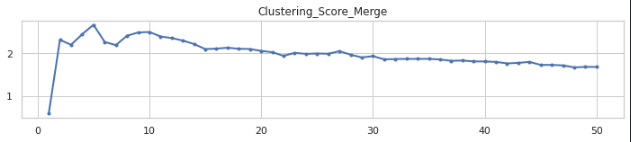

In [45]:
## 設定版型
# sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(12,10)})

# family_N_Specie = moth_meta.groupby("Family").SciName.nunique().sort_values()[::-1]   # 建立科名與物種數量的索引
# index_n_unions = np.load(f'{path_root}/meta/index_n_unions.npy', allow_pickle=True)
# df_Nuniun = pd.DataFrame([len(n) for n in index_n_unions], index=range(1,51), columns=["N_uniun"] )

# def cluster_ploting(reducer="PCA", n=None, dim=2, sample=100, save=None):

#     n_union = df_Nuniun.loc[n].item()                         
#     index = moth_meta[moth_meta.Fam_Specie > sample].index  # 指定取樣的科數。 依據樣本Fam_Sample 或依據物種數Fam_Specie
#     familys = family_N_Specie[family_N_Specie>sample].index    # 指定取樣的科。 依據各科物種數Fam_Specie
    
#     embedding_file = f"{reducer}_embedding_{dim}D_{n}N.npy"
#     embedding = pd.DataFrame(np.load(f'{path_root}/meta/embedding/{reducer}/{embedding_file}'))
    
#     fig = plt.figure()
#     cmap='Spectral'; lw=.1; s=9; edgecolors='black'; alpha=0.5  # parameters of ax.scatter
    
#     if dim==2: 
#         ax = plt.axes()
#         x=0.75; y=0.91 # suptitle loc
#         for family in familys:
#             index = moth_meta[moth_meta.Family == family ].index
#             scatter = ax.scatter(embedding.iloc[index, 0], embedding.iloc[index, 1],
#                         cmap=cmap, lw=lw, s=s, edgecolors=edgecolors, alpha=alpha)
#         fig.gca().set_aspect('equal', 'datalim')
        
#     if dim==3:
#         ax = Axes3D(fig)
#         x=0.75; y=1.03 # suptitle loc
#         for family in familys:
#             index = moth_meta[moth_meta.Family == family ].index
#             scatter = ax.scatter(embedding.iloc[index, 0], embedding.iloc[index, 1], embedding.iloc[index, 2],
#                                      cmap=cmap, lw=lw, s=s, edgecolors=edgecolors, alpha=alpha)
#         # 控制邊界
#         axisEqual3D(ax)
# #         xlim=6; ylim=6; zlim=6
# #         ax.set_xlim(-xlim, xlim); ax.set_ylim(-ylim, ylim); ax.set_zlim(-zlim, zlim)
        
#     # 取出legen元素，圖標 handles與 標籤labels
#     ax.legend(labels=familys, title='Family', ncol=5, markerscale=3, frameon=True)
    
#     plt.title(f'Clustering of\nMoth Features', fontsize=20, loc='center')
#     plt.suptitle(f'{reducer}\n N : {n},  N_union : {n_union}, species > {sample}', fontsize=10, fontweight='light', x=x, y=y)
    
#     if save==True:
#         plt.savefig(f"./results/{reducer}/{reducer}_{dim}D_{n}N_{n_union}Nunion_sample{sample}.png", bbox_inches='tight');

# def axisEqual3D(ax=None):
#     '''control axis limit for cluster_ploting'''
#     extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
#     sz = extents[:,1] - extents[:,0]
#     centers = np.mean(extents, axis=1)
#     maxsize = max(abs(sz))
#     r = 0.65 * maxsize / 2               # setting scale
#     for ctr, dim in zip(centers, 'xyz'):
#         getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

### 2.3 PCA降維(3軸)，在三軸上內插取樣、並inverse transform 回關鍵特徵後，使用decoder生成影像，檢視特徵維度的視覺變化
- 為了更進一步理解關鍵特徵的視覺意義，我們對其做 PCA，找出最主要的三軸(解釋度 34.9%)。
- 接著在三軸上均勻取樣並 inverse transform 回關鍵特徵。從 decoder 生成的影像中，可明確看出每一軸在外觀特徵上的意義，是為：展翅大小、翅膀形狀，與翅膀上的紋路(圖5)。

In [46]:
# n_unions, explained_variance_ratios = [], []
# for n in range(1,51):
#     features_ = get_Nunion_features (features=features, n=n, index_n_unions=index_n_unions)

#     pca = PCA(n_components=3)
#     mapper = pca.fit(features_)
#     explained_variance_ratio = pca.explained_variance_ratio_.sum()
#     n_unions.append(len(index_n_unions[n-1]))
#     explained_variance_ratios.append(100*explained_variance_ratio)
#     print(f'N : {n:2d}, N_union : {len(index_n_unions[n-1]):3d}, Explained_variance_ratio : {100*explained_variance_ratio:.2f} %', end='\r')

# df_ExRatios = pd.DataFrame( np.array([n_unions, explained_variance_ratios]).T,
#             index=range(1,51),
#             columns=["N_union","Explained_variance%"])

In [47]:
# sns.set(style='white', context='notebook', rc={'figure.figsize':(12,3)})

# plt.figure()
# ax = (df_ExRatios["Explained_variance%"]
# #       .set_index("N_union").sort_index()
#       .plot(grid=True, marker="."))
# ax.set(xlabel="N_union (Number of features)",
#        ylabel="Explained_variance %",
#        title="PCA Explained_variance"
#       )
# ax.annotate('Turning point\n(N_union=61)', xy=(5, 26), xytext=(5, 30),
#             arrowprops=dict(facecolor='black', shrink=.1));

#### note

- 當 N=5，N_union=61， n_components=3時，此三軸的解釋度為25.58%
- N / N_union 為線性關係，若N_union在任何維度的特徵傳遞的訊息量都一樣，理論上會看到Explained_variance_ratio的曲線呈線性下降
  - clustering metric score 最高分處亦為 Explained_variance_ratio快速下降的轉折點
  - 反映目前所選取的少量維度，已經傳遞出分群(科)訊息的代表性特徵

=== Baseline====
- N_union=512時(直接用原資料)， 三軸(3個主成分)的解釋力為20.35%。如果要取得90%的解釋力，主成分至少需要46個維度。  


- N=5，N_union=61 ， 主成分為三軸時的數值分布  


In [48]:
# from MothScripts.dataset import ImageDatasetFromFile
from MothScripts.networks import DFC_VSC_WGAN
from MothScripts.resnet50_classifier import ResNet50_family_classifier
from MothScripts.average_meter import AverageMeter

sns.set(style='white', context='notebook', rc={'figure.figsize':(12,3)})

#### load model 

In [49]:
def load_model(model, pretrained, map_location=None):
    weights = torch.load(pretrained, map_location=map_location)
    pretrained_dict = weights['model'].state_dict()  
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict) 
    model.load_state_dict(model_dict)

In [50]:
# 指定GPU位置
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

channels= [32, 64, 128, 256, 512, 512]
model = DFC_VSC_WGAN(channels=channels, discrimination=False)

ck = 5000
map_location = 'cuda:1'  # 'cuda:1'  or 'cpu'
ck_path = f'model/vsc_wgan/backup/model_local_epoch_{ck}_iter_0.pth' 
load_model(model, pretrained=ck_path, map_location=map_location)
model = model.cpu()

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'MothScripts.networks.DFC_VSC_WGAN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [51]:
features_ = get_Nunion_features (features=features, n=5, index_n_unions=index_n_unions)

#### PCA

In [ ]:
pca = PCA(n_components=3)
embedding = pca.fit_transform(features_)

df_embedding = pd.DataFrame(embedding)
print(df_embedding.describe())
# df_embedding.plot(kind="density", lw=3, grid=True);

<AxesSubplot:ylabel='Frequency'>

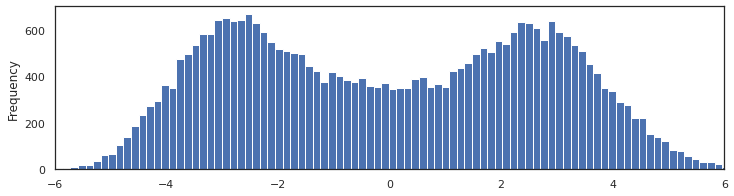

In [31]:
# df_embedding[0].plot(kind="hist", bins=100, xlim=(-6, 6))

In [38]:
linspace = 11
q = .01
upper = np.quantile(embedding, axis=0, q=(1-q) )
lower = np.quantile(embedding, axis=0, q=q)
base = np.zeros((linspace, 3))

for d in [0, 1, 2]:
    reducer_ = base.copy()  
    reducer_[:,d] = np.linspace(lower[d], upper[d], linspace)
    
    if d==0: 
        embedding_linespace = reducer_.reshape(1, linspace, -1)
    else:
        embedding_linespace = np.vstack((embedding_linespace, reducer_.reshape(1, linspace, -1)))
print("interpolation of embedding features: ", embedding_linespace.shape)

interpolation of embedding features:  (3, 11, 3)


In [39]:
for d in [0, 1, 2]:
    embedding_inv = pca.inverse_transform(embedding_linespace[d])
    if d==0: 
        features_linespace = embedding_inv.reshape(1, linspace, -1)
    else:
        features_linespace = np.vstack(
            (features_linespace, embedding_inv.reshape(1, linspace, -1))
        )
        
print("Inverse of interpolated embedding features: ", features_linespace.shape)

Inverse of interpolated embedding features:  (3, 11, 512)


In [40]:
features_linespace = torch.tensor(features_linespace, dtype=torch.float32).clone().detach()
with torch.no_grad():
    for d in [0, 1, 2]:
        if d==0:
            rec =  model.decoder(features_linespace[d]).reshape(1, linspace, 3, 256, 256) 
        else:
            rec = torch.cat(
                ( rec, 
                 model.decoder(features_linespace[d]).reshape(1, linspace, 3, 256, 256) )
            )
print(rec.shape)

torch.Size([3, 11, 3, 256, 256])


In [ ]:
fig_root =  f"./results/feature_inversed"
# im_convert(torchvision.utils.make_grid(rec.view(-1, 3, 256, 256), nrow=linspace), f_name=f"PCA_AxisbyRow",  save=True ,fig_root=fig_root, figsize=(18, 9))

##### Detailed Interpoaltion on Each Axis 

In [32]:
##　Interpoaltion on Axis0 
linspace = 50
base = np.zeros((linspace, 3))
embedding_linespace = np.linspace(-5, 5, linspace)
reducer_ = base.copy()
reducer_[:,0] = embedding_linespace
features_linespace = pca.inverse_transform(reducer_)

features_linespace = torch.tensor(features_linespace, dtype=torch.float32).clone().detach()
rec =  model.decoder(features_linespace).reshape(1, linspace, 3, 256, 256) 

In [ ]:
fig_root =  f"./results/feature_inversed"
# im_convert(torchvision.utils.make_grid(rec.view(-1, 3, 256, 256), nrow=10), f_name=f"PCA_Axis0", save=True ,fig_root=fig_root, figsize=(18, 12))

### Note
-  目前的影像採用bounding box 框選出影像，去掉體型大小變異，優點是可以單獨反映翅型對於分科、分群的重要性
-  VSC-ResNET的搭配，亦即判別器採用分科模型來比對原始影像與重建影像的底層特徵圖 => 屬於半監督式學習，監督的項目是比對分科特徵圖
   - 用GRADCAM檢視特徵圖可視化
   
### PCA
- 0 - 2 軸的主成分依序反映分科的重要特徵(變方解釋力依序為13.2% , 6.5%, 5.9%)
- 軸0型態變化：  
  1. 翅型。  
     - 平展狹長的翅型，過渡到力矩面積較大的翅型
       - 長距離、隨風力移動 - 適合短距離、複雜空間的飛行
     - 前後翅: 連結 - 分離
  2. 身體。 粗大 - 尖細
  3. 顏色。 淺色 - 暗色
- 軸1型態變化：
  1. 翅型。 前翅:平展 -上揚 、後翅:圓鈍-尖
  2. 身體。 翅膀面積與腹部比例，變化趨勢與軸０相反
  3. 觸角。 短 - 長
- 軸2型態變化: 
  1. 較明顯的翅膀斑紋變化
  2. 翅膀邊緣型態。平滑 - 波浪狀
  3. 身體。 長 -短(消失)
- 軸0數值呈現雙峰分布
  - 可能反應鱗翅目兩大翅型  
  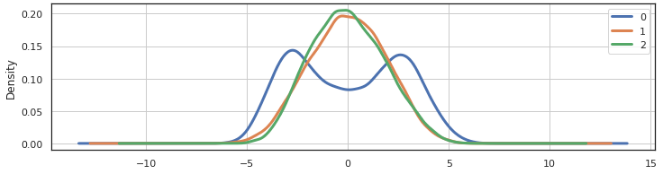

#### 關鍵特徵視覺化 - 降維後反轉回原特徵內插，檢視關鍵三軸(PCA)
- 每一列(row)依序代表軸0、1、2  
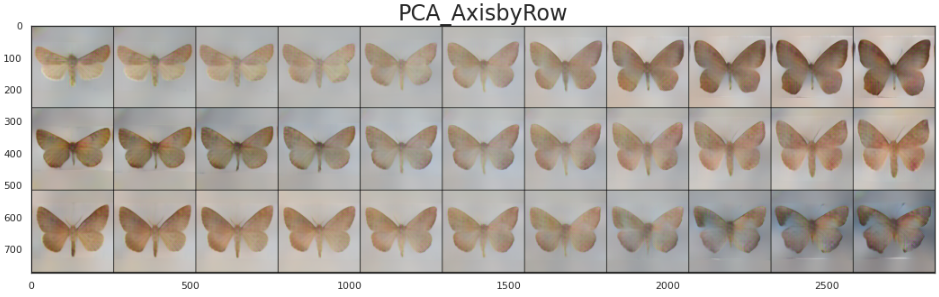

- 軸0放大內插檢視  
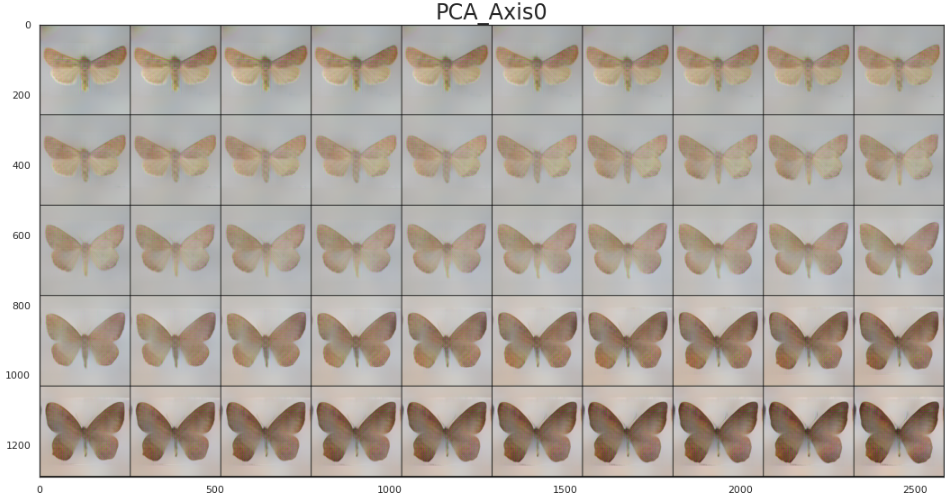

#### UMAP

In [163]:
n_neighbors = 500
umap = UMAP(n_components=3,n_neighbors=n_neighbors, verbose=True)
embedding = umap.fit_transform(features_)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=3, n_epochs=None,
     n_neighbors=500, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Mon Jun 28 15:43:41 2021 Finding Nearest Neighbors
Mon Jun 28 15:43:41 2021 Building RP forest with 14 trees
Mon Jun 28 15:43:41 2021 NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Mon Jun 28 15:48:32 2021 Finished Nearest Neighbor Search
Mon Jun 28 15:48:58 2021 Construct embedding
	completed  0  /  200 epo

In [ ]:
df_embedding = pd.DataFrame(embedding)
print(df_embedding.describe())
sns.set(style='white', context='notebook', rc={'figure.figsize':(12,3)})
# df_embedding.plot(kind="density", lw=3, grid=True, xlim=(0,13));

In [166]:
linspace = 11
q = .01
upper = np.quantile(embedding, axis=0, q=(1-q))
lower = np.quantile(embedding, axis=0, q=q)
base = np.zeros((linspace, 3))

for d in [0, 1, 2]:
    reducer_ = base.copy()  
    reducer_[:,d] = np.linspace(lower[d], upper[d], linspace)
    
    if d==0: 
        embedding_linespace = reducer_.reshape(1, linspace, -1)
    else:
        embedding_linespace = np.vstack((embedding_linespace, reducer_.reshape(1, linspace, -1)))
    print(f"Axis : {d},  {round(lower[d], 2)} - {round(upper[d], 2)}")
print("interpolation of embedding features: ", embedding_linespace.shape)

Axis : 0,  1.18 - 12.11
Axis : 1,  0.5 - 4.26
Axis : 2,  3.41 - 8.06
interpolation of embedding features:  (3, 11, 3)


In [167]:
for d in [0, 1, 2]:
    embedding_inv = pca.inverse_transform(embedding_linespace[d])
    if d==0: 
        features_linespace = embedding_inv.reshape(1, linspace, -1)
    else:
        features_linespace = np.vstack((features_linespace, embedding_inv.reshape(1, linspace, -1)))
        
print("Inverse of interpolated embedding features: ", features_linespace.shape)

Inverse of interpolated embedding features:  (3, 11, 512)


In [168]:
features_linespace = torch.tensor(features_linespace, dtype=torch.float32).clone().detach()
with torch.no_grad():
    for i in [0, 1, 2]:
        if i==0:
            rec =  model.decoder(features_linespace[i]).reshape(1, linspace, 3, 256, 256) 
        else:
            rec = torch.cat(
                ( rec, 
                 model.decoder(features_linespace[i]).reshape(1, linspace, 3, 256, 256) )
            )
print(rec.shape)

torch.Size([3, 11, 3, 256, 256])


In [ ]:
fig_root =  f"./results/feature_inversed"
# im_convert(torchvision.utils.make_grid(rec.view(-1, 3, 256, 256), nrow=linspace), f_name=f"UMAP", save=True , fig_root=fig_root, figsize=(18, 6))

#### UMAP
- 相較PCA，每一軸的曲線有多個峰值
  - 反映每一軸涵蓋的型態資訊較大  
  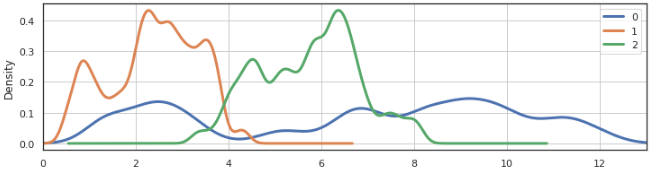  
  
- 軸0型態變化
  - 顏色變化。 淺 - 暗
  - 身體。 粗- 細
  - 翅型: 面積與力矩
- 軸1型態變化
  - 身體。粗- 細
  - 翅型。幾何形狀
- 軸2型態變化
  - 翅膀斑紋
  - 後翅輪廓:　平滑 - 波浪狀 

#### 關鍵特徵視覺化 - 降維後反轉回原特徵內插，檢視關鍵三軸(PCA)
- 每一列(row)依序代表軸0、1、2  
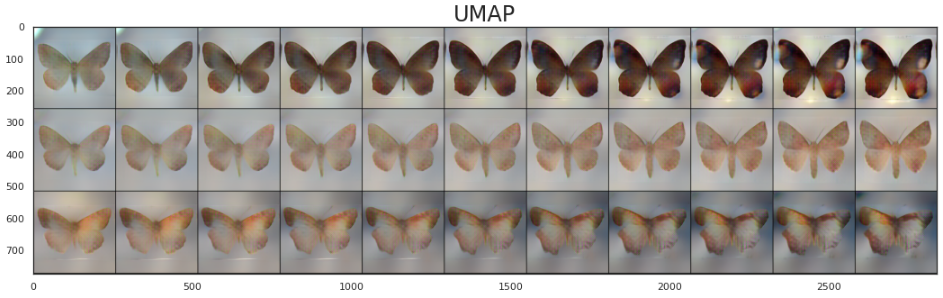

##### Detailed Interpoaltion on Each Axis 

In [171]:
q = .01
upper = np.quantile(embedding, axis=0, q=(1-q))
lower = np.quantile(embedding, axis=0, q=q)
print(lower)
print(upper)

max_upper = np.max(embedding, axis=0)
min_lower = np.min(embedding, axis=0)
print(min_lower)
print(max_upper)

[1.18318586 0.49679522 3.4113107 ]
[12.11426106  4.26335963  8.06073886]
[1.0226529  0.30213308 3.1214302 ]
[12.412249   4.5449586  8.278629 ]


In [ ]:
##　Interpoaltion on Axis0 
linspace = 50
dim = 0
base = np.zeros((linspace, 3))
embedding_linespace = np.linspace(lower[dim], upper[dim], linspace)
print(lower[dim], upper[dim])
reducer_ = base.copy()
reducer_[:,dim] = embedding_linespace
features_linespace = pca.inverse_transform(reducer_)

features_linespace = torch.tensor(features_linespace, dtype=torch.float32).clone().detach()
rec =  model.decoder(features_linespace).reshape(1, linspace, 3, 256, 256)

fig_root =  f"./results/feature_inversed"
# im_convert(torchvision.utils.make_grid(rec.view(-1, 3, 256, 256), nrow=10), f_name=f"UMAP_Axis{dim}", save=True ,fig_root=fig_root, figsize=(18, 12))

In [ ]:
##　Interpoaltion on Axis1
dim = 1
base = np.zeros((linspace, 3))
embedding_linespace = np.linspace(lower[dim], upper[dim], linspace)
print(lower[dim], upper[dim])
reducer_ = base.copy()
reducer_[:,dim] = embedding_linespace
features_linespace = pca.inverse_transform(reducer_)

features_linespace = torch.tensor(features_linespace, dtype=torch.float32).clone().detach()
rec =  model.decoder(features_linespace).reshape(1, linspace, 3, 256, 256)

fig_root =  f"./results/feature_inversed"
# im_convert(torchvision.utils.make_grid(rec.view(-1, 3, 256, 256), nrow=10), f_name=f"UMAP_Axis{dim}", save=True ,fig_root=fig_root, figsize=(18, 12))

In [ ]:
##　Interpoaltion on Axis2
dim = 2
base = np.zeros((linspace, 3))
embedding_linespace = np.linspace(lower[dim], upper[dim], linspace)
print(lower[dim], upper[dim])
reducer_ = base.copy()
reducer_[:,dim] = embedding_linespace
features_linespace = pca.inverse_transform(reducer_)

features_linespace = torch.tensor(features_linespace, dtype=torch.float32).clone().detach()
rec =  model.decoder(features_linespace).reshape(1, linspace, 3, 256, 256)

fig_root =  f"./results/feature_inversed"
# im_convert(torchvision.utils.make_grid(rec.view(-1, 3, 256, 256), nrow=10), f_name=f"UMAP_Axis{dim}", save=True ,fig_root=fig_root, figsize=(18, 12))